## Imports

In [1]:
!pip install "deeplake<4"
!pip install --upgrade transformers
!pip install nltk
!pip install torchvision

In [2]:
!pip install --upgrade opencv-python opencv-python-headless

In [3]:
import torch
import torch.nn as nn

import deeplake
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import os

from torchvision import transforms
from transformers import BertTokenizer, BertModel
import nltk
import random

from torch.utils.data import Dataset
from PIL import Image

/Users/joshdeleeuw/opt/anaconda3/lib/python3.9/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.0.3) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
/Users/joshdeleeuw/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Part I : Video to Frames

In [4]:
def extract_frames_with_opencv(video_path, output_dir, gap):
    """
    Extracts and saves frames from a video at specified intervals.

    Parameters:
    - video_path (str): Path to the video file.
    - output_dir (str): Directory to save the extracted frames.
    - gap (int): Interval between frames to save (e.g., every 10th frame).

    Returns:
    - list of str: Paths to the saved frame images, or an empty list if the video cannot be opened.

    The function captures frames from the specified video file, saving every nth frame defined by the gap parameter.
    It logs the process, including the number of frames processed and saved. Errors in opening the video are also logged.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Cannot open video file {video_path}")
        return []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    print(f"Video FPS: {fps}, Total frames: {total_frames}")

    frame_count = 0
    saved_count = 0
    image_paths = []

    while True:
        ret, frame = cap.read()
        if not ret:
            print(f"End of video or frame read failed at frame {frame_count}.")
            break

        if frame_count % gap == 0:
            image_path = os.path.join(output_dir, f"frame_{saved_count*gap}.jpg")
            cv2.imwrite(image_path, frame)
            image_paths.append(image_path)
            saved_count += 1
            print(f"Saved frame {frame_count} to {image_path}")

        frame_count += 1

    cap.release()
    print(f"Total frames processed: {frame_count}")
    print(f"Total frames saved: {saved_count}")
    return image_paths

In [5]:
# example run
video_path = "try.mp4"
output_dir = "extracted_images"
gap = 20

extracted_images = extract_frames_with_opencv(video_path, output_dir, gap)
print("Extracted image paths:", extracted_images)

Video FPS: 25, Total frames: 216
Saved frame 0 to extracted_images/frame_0.jpg
Saved frame 20 to extracted_images/frame_20.jpg
Saved frame 40 to extracted_images/frame_40.jpg
Saved frame 60 to extracted_images/frame_60.jpg
Saved frame 80 to extracted_images/frame_80.jpg
Saved frame 100 to extracted_images/frame_100.jpg
Saved frame 120 to extracted_images/frame_120.jpg
Saved frame 140 to extracted_images/frame_140.jpg
Saved frame 160 to extracted_images/frame_160.jpg
Saved frame 180 to extracted_images/frame_180.jpg
Saved frame 200 to extracted_images/frame_200.jpg
End of video or frame read failed at frame 216.
Total frames processed: 216
Total frames saved: 11
Extracted image paths: ['extracted_images/frame_0.jpg', 'extracted_images/frame_20.jpg', 'extracted_images/frame_40.jpg', 'extracted_images/frame_60.jpg', 'extracted_images/frame_80.jpg', 'extracted_images/frame_100.jpg', 'extracted_images/frame_120.jpg', 'extracted_images/frame_140.jpg', 'extracted_images/frame_160.jpg', 'extra

# Part II : Image Captioning

## Preprocessing Data, Tokenizing

This was also part of our demo1 submission

In [6]:
ds = deeplake.load('hub://activeloop/flickr30k')

-

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/flickr30k



\

hub://activeloop/flickr30k loaded successfully.



In [7]:
images = ds.image
captions = ds.caption_0 ## NextSteps: currently only training on caption0, could include other set of captions

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [9]:
caption_max_length = 20
vocab_size = len(tokenizer)

In [10]:
def process_image(image):
  """
  Image transformation functions
  Resizes images to 224x224, converts to tensor, and normalizes
  The normalization parameters are mean, SD of of r, g, b pixel values
  """
  image_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  image = image.numpy()
  image = Image.fromarray(image)
  image = image_transform(image)
  return image


def process_caption(caption_text):
  """
  Tokenizes captions
  Returns tensor of tokenized captions, with a max length of 20,
  padding until this length, and truncating if the caption is longer
  The individual entries in the tensor are integers
  """

  tokenized = tokenizer(caption_text,
                        max_length=caption_max_length,
                        padding='max_length',
                        truncation=True,
                        return_tensors='pt')

  input_ids = tokenized['input_ids']
  attention_mask = tokenized['attention_mask']
  return input_ids

def untokenize(tokenized_text):
    """
    Untokenizes a tensor
    Takes a tensor of integers, and according to tokenizer, returns
    original words
    """
    return tokenizer.decode(tokenized_text, skip_special_tokens=True)


### Tests

Tokenizer Tests

In [11]:
strings = ["hello world", "my dog went to the store", "the earth revolves around the sun",
           "I travelled to new york city and ate mexican and japanese food"]

def test_tokenizer(strings):
    """
    Function to test tokenizer, by tokenizing and untokenizing a string
    """
    for string in strings:
        # print ("input string: " + string)
        check = untokenize(process_caption(string)[0])
        # print ("output string: " + check)
        assert check.lower() == string.lower()
    print("All tests passed!")
test_tokenizer(strings)

All tests passed!


In [12]:
tokenizer.tokenize("Hello I am Wendy")
tokenizer.encode("Hello I am Wendy", add_special_tokens = True)

[101, 7592, 1045, 2572, 12815, 102]

Data Processing Tests

In [13]:
def test_process_image():
  test_img = ds.image[0]
  transformed_img = process_image(test_img)
  assert transformed_img.size(1) == 224 and transformed_img.size(2) == 224, "Image resizing failed."
  assert transformed_img.size(0) == 3, "Image channel mismatch."
  print("All tests passed!")

test_process_image()


All tests passed!


In [14]:
def test_process_caption():
  caption = "A dog playing in the park."
  input_ids = process_caption(caption)
  assert input_ids.size(1) == 20, "Tokenized length incorrect."

  decoded_caption = untokenize(input_ids[0])
  assert decoded_caption.lower() == caption.lower(), "Caption untokenization incorrect."
  print("All tests passed!")
test_process_caption()

All tests passed!


## Dataset/Dataloader Creation

In [15]:
class Flickr30kDataset(Dataset):
    def __init__(self, images, captions, image_transform=None, caption_transform = None):
      """
      Initializes dataset
      """
      self.images = images
      self.captions = captions
      self.image_transform = image_transform
      self.caption_transform = caption_transform

    def __len__(self):
      """
      Returns length of the dataset
      """
      return len(self.captions)

    def __getitem__(self, idx):
      """
      Returns a single item (image, and caption processed according to
      caption_transform) from the dataset
      """
      image = self.images[idx]
      image = self.image_transform(image)

      caption = self.captions[idx].numpy()[0]
      caption_embedding = self.caption_transform(caption)
      return image, caption_embedding


In [16]:
from torch.utils.data import DataLoader, random_split

flickr_dataset = Flickr30kDataset(images, captions, image_transform=process_image, caption_transform=process_caption)

# 80% train, 10% val, 10% Test
train_size = int(0.8 * len(flickr_dataset))
val_size = int(0.1 * len(flickr_dataset))
test_size = len(flickr_dataset) - train_size - val_size

train_dataset, eval_dataset, test_dataset = random_split(flickr_dataset, [train_size, val_size, test_size])

batch_size = 32 # TODO
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
## SMALLER DATASET FOR SAMPLE
from torch.utils.data import Subset
import random

train_n = 10
eval_n = 2
batch = 1

train_indices = random.sample(range(len(flickr_dataset)), train_n)
train_subset = Subset(flickr_dataset, train_indices)
mini_train_dataloader = DataLoader(train_subset, batch_size=batch, shuffle=False)

eval_indices = random.sample(range(len(flickr_dataset)), eval_n)
eval_subset = Subset(flickr_dataset, eval_indices)
mini_eval_dataloader = DataLoader(eval_subset, batch_size=batch, shuffle=False)

#### Tests

In [18]:
def test_flickr30k_dataset():
    dataset = Flickr30kDataset(images, captions, image_transform=process_image, caption_transform=process_caption)
    assert len(dataset) == len(captions), "Dataset length mismatch."

    image, caption_embedding = dataset[0]
    assert image.size(0) == 3 and image.size(1) == 224 and image.size(2) == 224, "Image shape incorrect."
    assert caption_embedding.size(1) == 20, "Caption max length incorrect."
    print("All tests passed!")

test_flickr30k_dataset()

All tests passed!


## Transformer-Based Image Captioning
Loosely based on : https://www.tensorflow.org/text/tutorials/image_captioning

Steps :  

1. Feature Extraction of Image (CNN)

2. Word Embedding : word + positional embedding

3. Decode Layer : Self attention, Cross Attention, Feed Forward Neural Network

4. Output : Post Processing of probability vector

## Feature Extraction

In [19]:
class CNN_feature_extraction(nn.Module):
  def __init__(self):
    """
    Initializes convolutional neural network
    """
    super(CNN_feature_extraction, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1).to(device) # (224,224,64)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1).to(device)# (224,224,128)
    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1).to(device)# (224,224,256)

    self.relu = nn.ReLU()
    self.fc = nn.Linear(256 * 28 * 28, 512).to(device)
    self.fc2 = nn.Linear(512, 256).to(device)
    self.flatten = nn.Flatten()

    self.maxPool = nn.MaxPool2d(2, 2).to(device)

    self.batchNorm1 = nn.BatchNorm2d(64).to(device)
    self.batchNorm2 = nn.BatchNorm2d(128).to(device)
    self.batchNorm3 = nn.BatchNorm2d(256).to(device)

  def forward(self, x):
    """
    Forward pass of convolutional neural network
    Note: Output is already flattened
    """
    # for each layer, run convolutional layer, batch normalization layer,
    # then maxPool layer
    layer1 = self.maxPool(self.relu(self.batchNorm1(self.conv1(x)))) # batch_size, 64, 112, 112 (b, c , h, w )
    layer2 = self.maxPool(self.relu(self.batchNorm2(self.conv2(layer1)))) # batch_size, 128, 56, 56
    layer3 = self.maxPool(self.relu(self.batchNorm3(self.conv3(layer2)))) # batch_size, 256, 28, 28
    x1 = self.flatten(layer3)  # 1, 200704 = 256*28*28
    hidden = self.relu(self.fc(x1))
    x = self.fc2(hidden) # 1, 256
    return x

#### Tests for feature extractions

In [20]:
def test_feature_extraction():
    data_iter = iter(mini_eval_dataloader)
    batch = next(data_iter)
    images, labels = batch

    image = images[0].to(device)
    label = labels[0].to(device)  # Corresponding label (if available)

    feature_extractor = CNN_feature_extraction()
    features = feature_extractor(image.unsqueeze(0))
    assert features.size(0) == 1, "CNN dimension batch size incorrect."
    assert features.size(1) == 256, "CNN dimension incorrect."
    print("Test Passed!")

device = "cuda" if torch.cuda.is_available() else "cpu"
test_feature_extraction()

Test Passed!


## Embedding Layer
Embedding = Word + Positional Embedding.

In [21]:
## Hyperparameter
embed_dim = 256

In [22]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, max_length, dim):
        """
        Combines token and positional embeddings to produce sequence embeddings for Transformers.
        Input:
          vocab_size: size of vocab. Used for token embedding
          max_length: max length of caption. Used for positional embedding
          dim: Dimension of embedding vectors. Dimension of both token and positional Embedding
        """

        super().__init__()
        self.pos_embedding = nn.Embedding(num_embeddings=max_length, embedding_dim=dim).to(device)
        self.token_embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=dim, padding_idx=0).to(device) # ie padding_idx that = 0 will not be trained

    def forward(self, caption):
        """
          Input: Caption (batch, max_length = 20)
          Output: Embedding (batch, max_length, dim)
        """
        _, max_length = caption.shape

        token_embed = self.token_embedding(caption)

        # Create a positional array with length = caption length (20)
        positional_indices = torch.arange(max_length, device=caption.device).unsqueeze(0).to(device) # 1, 20
        position_embed = self.pos_embedding(positional_indices)

        return token_embed + position_embed

#### Test for embedding layer

In [23]:
def test_embedding_layer():
    data_iter = iter(mini_eval_dataloader)
    batch = next(data_iter)
    images, labels = batch

    image = images[0].to(device)
    label = labels[0].to(device)  # Corresponding label (if available)

    embedding = Embedding(vocab_size,caption_max_length,embed_dim)
    seq_embed = embedding(label)
    assert seq_embed.shape == (1,caption_max_length,embed_dim), "CNN dimension incorrect."
    print("Test Passed!")

device = "cuda" if torch.cuda.is_available() else "cpu"
test_embedding_layer()

Test Passed!


## Decoder
Contains self attention, cross attention, feed forward neural network

In [24]:
## Hyperparameters
num_heads = 1
dropout =  0.1

### Self Attention Layer

In [25]:
class SelfAttention(nn.Module):
    """
    Self-Attention mechanism for token embeddings. Capture dependencies between words.

    Inputs:
        embed_dim: Embedding dimension = embed_dim
        num_heads: The number of attention heads. Each head learns different aspects of the relationships between tokens.
        dropout: Dropout rate used to prevent overfitting
    """
    def __init__(self,  num_heads = 1, embed_dim = embed_dim, dropout=0.1):
        super(SelfAttention, self).__init__()


        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout).to(device)
        self.layernorm = nn.LayerNorm(embed_dim).to(device)

    def forward(self, x_token):
        """
        input shape : (batch, max_length, dim)
        output shape : (batch, max_length, dim)
        """
        attn_output, attn_output_weights = self.attention(query=x_token, key=x_token, value=x_token)
        x = x_token + attn_output  #Residual connection prevent vanishing grad
        return self.layernorm(x)

### Cross Attention Layer

In [26]:
class CrossAttention(nn.Module):
    """
    Cross Attention between caption and image.

    Input:
        Caption Embedding : (batch, seq_length, embed_dim)
        Image Feature Extraction : (batch, 256)
    """

    def __init__(self, embed_dim, num_heads=1, dropout=0.1):
        super(CrossAttention, self).__init__()
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout).to(device)
        self.layernorm = nn.LayerNorm(embed_dim).to(device)

    def forward(self, caption, image):
        batch_size_c, seq_length, embed_dim = caption.shape
        batch_size_i, image_embed = image.shape
        assert batch_size_c == batch_size_i, "Batch Dimension of image and caption does not match"
        assert image_embed == 256, "Image Shape Incorrect"
        assert image_embed == embed_dim , "Image dimension does not match Token dimension"

        # create the same image for seq_length
        image_broadcasted = image.unsqueeze(1).repeat(1, seq_length, 1) # batch, seq_length, image_dim
        attn_output, attention_scores = self.mha(query=caption, key=image_broadcasted, value=image_broadcasted)
        caption = caption + attn_output  # Residual connection
        self.last_attention_scores = attention_scores
        return self.layernorm(caption)  #(batch, max_length, image_dim)

### Feed Forward Neural Network

In [27]:
class FeedForward(nn.Module):
    """
    Initializes feed forward layer, which passed data along to the 
    next layer
    """
    def __init__(self, embed_dim, dropout_rate=0.1):
        super(FeedForward, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(embed_dim, 2 * embed_dim).to(device),
            nn.ReLU(),
            nn.Linear(2 * embed_dim, embed_dim).to(device),
            nn.Dropout(dropout_rate)
        )
        self.layernorm = nn.LayerNorm(embed_dim).to(device)

    """
    Runs forward pass of the deocder layer
    """
    def forward(self, x):
        x = x + self.layer(x).to(device)
        return self.layernorm(x)


### Decoder Layer

In [28]:
class DecoderLayer(nn.Module):
    """
    Initializes full decoder layer, including self/cross attention layers
    and feed forward network
    """
    def __init__(self, embed_dim, num_heads=1, dropout=0.1):
        super(DecoderLayer, self).__init__()

        self.self_attention = SelfAttention(num_heads, embed_dim, dropout)
        self.cross_attention = CrossAttention(embed_dim, num_heads, dropout)
        self.ffnn = FeedForward(embed_dim, dropout)

    def forward(self, inputs):
        image, caption = inputs
        caption_1 = self.self_attention(caption)
        output_seq = self.cross_attention(caption_1, image)
        out_seq = self.ffnn(output_seq)

        self.last_attention_scores = self.cross_attention.last_attention_scores

        return out_seq # batch, seq_length, embed_dim

## PostProcessing

1. Problem: Some tokens occur much more frequently than others in the dataset.
Without adjustment, the model may develop a bias toward predicting these frequent tokens, regardless of context.
Incorporate token frequency information in the logits using the bias term.
For instance, less frequent tokens are given a higher weight, encouraging the model to predict them when appropriate.

2. Problem: Some tokens, like [UNK] or [START], are placeholders or special tokens not intended for prediction.
Solution:
Add a large negative bias (-1e9) to these tokens' logits to make their probabilities effectively zero after softmax.
This guarantees they are not predicted during decoding.

In [29]:
import collections
from tqdm import tqdm

In [30]:
class PostProcessing(nn.Module):
    def __init__(self, embed_dim, tokenizer, banned_tokens=('[UNK]', '[PAD]', '[SEP]', '[CLS]', '[MASK]', 'the', 'a', 'in')):

        super(PostProcessing, self).__init__()
        self.vocab_size = tokenizer.vocab_size
        self.tokenizer = tokenizer
        self.fc = nn.Linear(embed_dim, out_features=tokenizer.vocab_size).to(device) ## Goal is to map to vocab size # batch, seq_length, vocab_size
        self.banned_tokens = banned_tokens

        self.bias = None

    def adapt(self, dataset):
        """
            vocab_dict: a dictionary to map vocab word to assigned index (from 0 to vocab_size)
            counts : a dictionary holding frequency of each word(token), key: id value :freq
        """
        counts = collections.Counter()
        vocab_dict = {name: id for id, name in enumerate(self.tokenizer.vocab)} # map name to id


        for tokens in tqdm(dataset):
            counts.update(tokens.numpy().flatten())  # Update freq for token in the sentence

        # Turn Frequency into an array of all vocabulary
        # fill vocab array with freq
        # array indices = token_id
        counts_arr = np.zeros(shape=(self.vocab_size,))
        indices = np.array(list(counts.keys()), dtype=np.int32)
        counts_arr[indices] = list(counts.values())


        for token in self.banned_tokens:
            id = vocab_dict[token]
            counts_arr[id] = 0

        total = counts_arr.sum()
        p = counts_arr / total
        p[counts_arr == 0] = 1.0  # Prevent log(0)
        log_p = np.log(p)  # log(1) == 0

        entropy = -(log_p * p).sum()

        # print(f"\nUniform entropy: {np.log(self.tokenizer.vocab_size):0.2f}")
        # print(f"Marginal entropy: {entropy:0.2f}")

        self.bias = torch.tensor(log_p, dtype=torch.float32)
        self.bias[counts_arr == 0] = -1e9  # Set large negative values for banned tokens

    def forward(self, input):
        input = input.float()
        x = self.fc(input)
        # x = x + self.bias.to(x.device)  # Ensure bias is on the same device as the input
        return x

## Image Captioner : Put it all together

In [31]:
banned_tokens=('[UNK]', '[PAD]', '[SEP]', '[CLS]', '[MASK]', 'the', 'a', 'in')

class ImageCaption(nn.Module):
    def __init__(self, tokenizer, vocab_size, num_layers=1, embed_dim=256, max_length=20, num_heads=2, dropout=0.1):
        super(ImageCaption, self).__init__()

        self.feature_extractor_model = CNN_feature_extraction()
        self.embedding = Embedding(vocab_size , max_length, embed_dim)
        self.decoder_layer = DecoderLayer(embed_dim)
        self.post_processing_model = PostProcessing(256, tokenizer, banned_tokens = banned_tokens)

        self.tokenizer = tokenizer

        # self.decoder_layers = nn.ModuleList([
        #     DecoderLayer(embed_dim)
        #     for _ in range(num_layers)
        # ])


    def forward(self, inputs):
        image, caption = inputs

        # Step 1: Extract Features
        extracted_image = self.feature_extractor_model(image)

        # Step 2: Embed the tokens
        tokens = self.embedding(caption)

        # Step 3: Decode
        token_output = self.decoder_layer((extracted_image, tokens))

        output = self.post_processing_model(token_output)

        return output

## Training/Predicting Version 1 (Old)

This may be modified and used for our final submission, but is not a major part of demo2.

In [32]:
import os

os.makedirs("./model_checkpoint", exist_ok=True)

def save_checkpoint(model, optimizer, epoch, path="model_checkpoint.pth"):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch + 1  # Save the next epoch to resume correctly
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at {path}")

def train_model_one(model, dataloader, optimizer, criterion, epochs, tokenizer, device):
    """"
    Trains image captioning model on input data
    Parameters:
      model: image captioning model
      dataloader: object to load dataset
      optimizer: algorithm to update weights
      criterion: used for calculating loss function
      epochs: number of epochs to run
      tokenizer: tokenizer to use for model
      device: device model runs on (cuda or cpu)
    """
    model.train()
    count = 0
    for image, c in mini_train_dataloader:
      captions_list = c[0][0].tolist()  # Convert tensor to list
      decoded_captions = [tokenizer.decode(cap) for cap in captions_list]

      if count == 0:
        all_captions = torch.empty(0, dtype=c.dtype, device=c.device)
      count += 1
      all_captions = torch.cat((all_captions, c.flatten()))

    model.post_processing_model.adapt(all_captions)

    for epoch in range(epochs):
        print("working on epoch ", epoch)
        total_loss = 0

        for images, captions in dataloader:
            #images = batch['images'].to(device)
            #captions = batch['captions'].to(device)


            images = images.to(device)
            captions = captions.to(device).long()

            decoder_input = captions.squeeze(1)[:, :-1]
            targets = captions.squeeze(1)[:, 1:]

            outputs = model((images, decoder_input))
            loss = criterion(outputs.view(-1, tokenizer.vocab_size), targets.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(dataloader):.4f}")

        # Save checkpoint after every epoch
        save_checkpoint(model, optimizer, epoch, path=f"./model_checkpoint/checkpoint_epoch_{epoch+1}.pth")

In [33]:
image_caption_model = ImageCaption(tokenizer, vocab_size)
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 10
model = image_caption_model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_model_one(model, mini_train_dataloader, optimizer, criterion, epochs, tokenizer, device)

100%|██████████| 200/200 [00:00<00:00, 36330.05it/s]


working on epoch  0
Epoch [1/10], Loss: 9.4235
Checkpoint saved at ./model_checkpoint/checkpoint_epoch_1.pth
working on epoch  1
Epoch [2/10], Loss: 6.6837
Checkpoint saved at ./model_checkpoint/checkpoint_epoch_2.pth
working on epoch  2
Epoch [3/10], Loss: 5.0699
Checkpoint saved at ./model_checkpoint/checkpoint_epoch_3.pth
working on epoch  3
Epoch [4/10], Loss: 4.4664
Checkpoint saved at ./model_checkpoint/checkpoint_epoch_4.pth
working on epoch  4
Epoch [5/10], Loss: 4.3211
Checkpoint saved at ./model_checkpoint/checkpoint_epoch_5.pth
working on epoch  5
Epoch [6/10], Loss: 4.2897
Checkpoint saved at ./model_checkpoint/checkpoint_epoch_6.pth
working on epoch  6
Epoch [7/10], Loss: 4.1527
Checkpoint saved at ./model_checkpoint/checkpoint_epoch_7.pth
working on epoch  7
Epoch [8/10], Loss: 4.1706
Checkpoint saved at ./model_checkpoint/checkpoint_epoch_8.pth
working on epoch  8
Epoch [9/10], Loss: 4.1920
Checkpoint saved at ./model_checkpoint/checkpoint_epoch_9.pth
working on epoch  9

Predicted Caption: a a a a a a a a a is a a a a a a a a a a


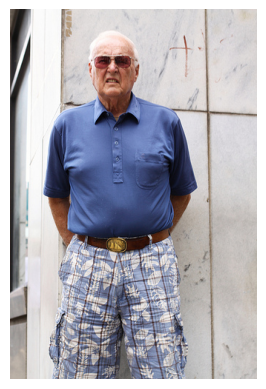

Predicted Caption: a a a in a a a a a a a a a a a a a a a


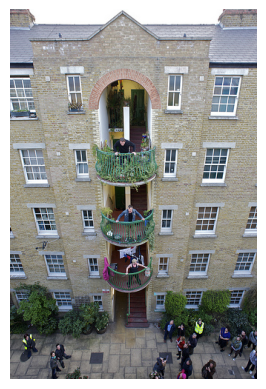

Predicted Caption: a a a a a a a a a a a a a a a a a a a a


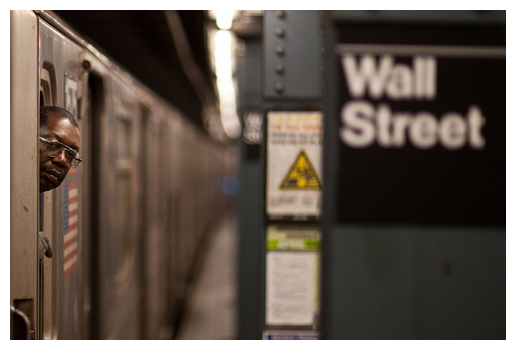

Predicted Caption: a a a a a a a a a a a a a a a a a a a a


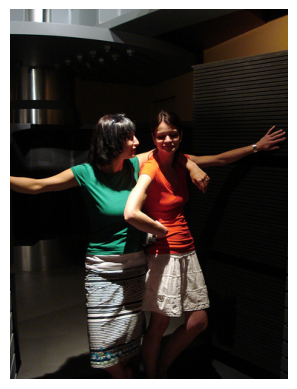

Predicted Caption: a a a a a a a a a a a in a a a a a a a a


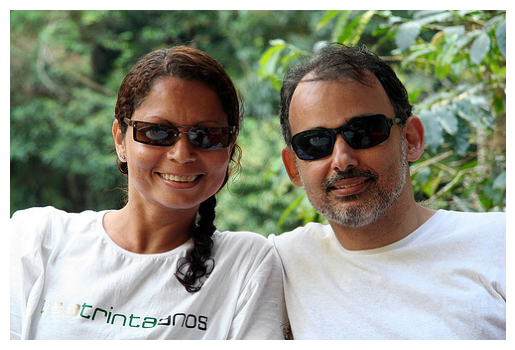

Predicted Caption: a a a a a a a a a is and a the a a a a a a


Predicted Caption: a a a a a a a a a a a a a a a a a a a a


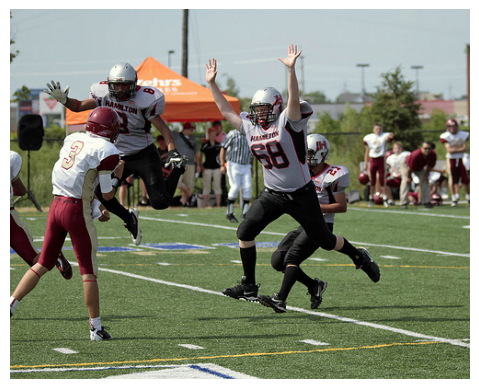

Predicted Caption: a a a a a a a a a a a a a in a a a a a


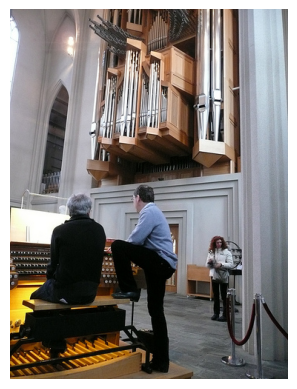

Predicted Caption: a a a a a a a a a a a in a a a a a a a a


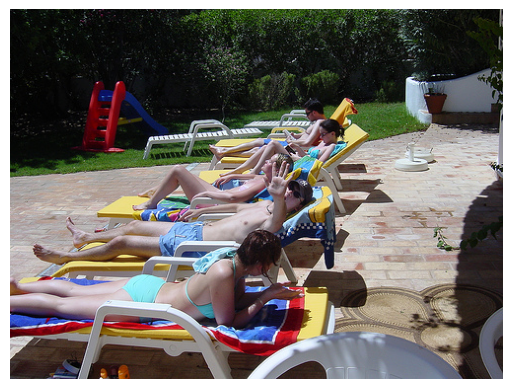

Predicted Caption: a a a a a a a a a a a in a a a a a a a a


In [34]:
checkpoint_path = "./model_checkpoint/checkpoint_epoch_10.pth"

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def predict_one(model, dataset, image, idx, device, max_length=20):
    """
    Predict the caption for an image from the dataset at a given index.
    Args:
        model: The trained ImageCaption model.
        dataset: The deeplake dataset containing images.
        idx: The index of the image in the dataset.
        device: The device (CPU or GPU) to run the model on.
        max_length: Maximum length of the generated caption.
    Returns:
        The predicted caption as a string.
    """
    # Load and preprocess the image
    # image = dataset.image[idx].numpy()
    # processed_image = process_image(image).unsqueeze(0).to(device)
    image = image.to(device)

    # Start the generation process
    with torch.no_grad():
        # Step 1: Extract image features

        extracted_image = model.feature_extractor_model(image)

        # Step 2: Start with the <START> token
        captions = torch.full(
            (1, 1), tokenizer.convert_tokens_to_ids("<START>"),
            dtype=torch.long, device=device
        )

        # Step 3: Autoregressively generate caption
        for _ in range(max_length):
            # Embed tokens
            token_embeddings = model.embedding(captions)

            # Decode with cross-attention
            token_output = model.decoder_layer((extracted_image, token_embeddings))

            # Post-process to predict the next token
            logits = model.post_processing_model(token_output[:, -1, :])  # Use the last token's output
            next_token = logits.argmax(dim=-1).unsqueeze(1)  # Select the most probable token

            # Append the next token to the captions
            captions = torch.cat([captions, next_token], dim=1)

            # Stop if the <END> token is generated
            if next_token.item() == tokenizer.convert_tokens_to_ids("<END>"):
                break

    # Untokenize the generated tokens
    return untokenize(captions.squeeze(0).tolist())

# Predict for a specific image
for index in range(10, 20):
  plt.imshow(ds.image[index].numpy())
  plt.axis('off')
  plt.show()

  test_image = ds.image[index]
  processed_test_image = process_image(test_image).unsqueeze(0)
  predicted_caption = predict_one(model, ds, processed_test_image, index, device)
  print(f"Predicted Caption: {predicted_caption}")

# Training/Evaluation/Prediction Version 2 (New)

This is what we will be mainly demoing during demo 2.

In [35]:
def banned_tokens_to_ids(tokenizer, banned_tokens):
  """
  Returns the IDs of banned tokens, according to tokenizer
  """
  res = []
  vocab_dict = {name: id for id, name in enumerate(tokenizer.vocab)}
  for token in banned_tokens:
    id = vocab_dict[token]
    res.append(id)
  print (res)
  return res

In [36]:
banned_token_ids = banned_tokens_to_ids(tokenizer, banned_tokens)

[100, 0, 102, 101, 103, 1996, 1037, 1999]


In [37]:
import os

os.makedirs("./model_checkpoint_new", exist_ok=True)

def save_checkpoint(model, optimizer, epoch, path="model_checkpoint.pth"):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch + 1  # Save the next epoch to resume correctly
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at {path}")

def train_model_new(cnn_feature_extraction, embedder, decoder, post_processor, banned_token_ids, data_loader, device="cpu", num_epochs = 10):
  """
    Trains image captioning model on input data
    Parameters:
      cnn_feature_extraction, embedder, decoder, post-processor : model components
      banned_token_ids : list of banned token ids
      data_loader: object to load dataset
      device: device model runs on (cuda or cpu)
      num_epochs: number of epochs to run  
  """

  print ("device is: " + str(device))

  cnn_feature_extraction.train()
  cnn_feature_extraction.train()
  embedder.train()
  decoder.train()
  post_processor.train()

  for epoch in range(num_epochs):

    total_loss = 0.0

    count = 0
    # run post-processor adapt on all captions
    for image, c in data_loader:
      captions_list = c[0][0].tolist()  # Convert tensor to list
      decoded_captions = [tokenizer.decode(cap) for cap in captions_list]

      if count == 0:
        all_captions = torch.empty(0, dtype=c.dtype, device=c.device)
      count += 1
      all_captions = torch.cat((all_captions, c.flatten()))

    post_processor.adapt(all_captions)

    for images, captions in data_loader:
      images = images.to(device)
      captions = captions.to(device).long()

      batch_size = len(images) # set number of images

      optimizer_cnn.zero_grad()
      optimizer_embedder.zero_grad()
      optimizer_decoder.zero_grad()
      optimizer_post_processor.zero_grad()

      # feature extraction
      features = cnn_feature_extraction(images)  # shape: 1 x 256
      captions = captions.squeeze(1)

      # list to store full outputs
      outputs = []    # shape: length (grows) * 1 * vocab_size

      # store specific word tokens that have been chosen
      token = torch.full((batch_size, 1), tokenizer.cls_token_id).to(device)  # shape: batch * 1
      seq_length = captions.size(1)
      predicted_words = set()
      for t in range(1, seq_length):
        # run embedder, decoder
        post_embed = embedder(token)  # shape: batch * token_length (t) * embed_dim

        output = decoder((features, post_embed))  # shape: batch * token_length * embed_dim

        # select the last word
        output_new = output[:, -1, :]    # shape: batch * 1 * embed_dim

        # run through post processing to get vocab size dimension
        after_post_process_og = post_processor(output_new)    # shape: batch * vocab_size
        after_post_process = after_post_process_og.clone().detach()

        for word in predicted_words:
          after_post_process[:, word] -= 1e9

        outputs.append(after_post_process_og)

        # teacher forcing
        ratio = 0.5 - 0.05 * epoch
        if random.random() < ratio:
          next_word = captions[:, t]
        else:
          next_word = torch.argmax(after_post_process, dim=1)   # gets most likely word

        predicted_words.add(next_word)

        token = torch.cat((token, next_word.unsqueeze(0)), dim=1)   # shape: batch * token_length

        if next_word[0] == tokenizer.sep_token_id:   # if ending word: break
          break

      outputs = torch.stack(outputs, dim=1)  # shape: batch * (seq_length - 1) * vocab_size
      outputs = outputs.reshape(-1, outputs.size(2))   # shape: (seq_length - 1) * vocab_size (or shorter in first dim if early termination)

      caption_original = captions[:, 1:]
      caption_original = caption_original.contiguous().view(-1) # shape: (seq-length - 1)

      # computes loss
      length = outputs.shape[0]
      if length < caption_original.shape[0]:
        caption_original = caption_original[:length]

      # don't include banned tokens in loss
      mask_banned = torch.isin(caption_original, torch.tensor(banned_token_ids).to(device))

      mask = ~mask_banned

      outputs = outputs[mask]
      caption_original = caption_original[mask]

      loss = criterion(outputs, caption_original)

      loss.backward()
      optimizer_cnn.step()
      optimizer_embedder.step()
      optimizer_decoder.step()
      optimizer_post_processor.step()
      total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

In [38]:
torch.autograd.set_detect_anomaly(True)

image_caption_model = ImageCaption(tokenizer, vocab_size)

cnn_feature_extraction = image_caption_model.feature_extractor_model
embedder = image_caption_model.embedding
decoder = image_caption_model.decoder_layer
post_processor = image_caption_model.post_processing_model

device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn_feature_extraction.parameters(), lr=0.001)
optimizer_embedder = torch.optim.Adam(embedder.parameters(), lr=0.001)
optimizer_decoder = torch.optim.Adam(decoder.parameters(), lr=0.001)
optimizer_post_processor = torch.optim.Adam(post_processor.parameters(), lr=0.001)

num_epochs = 10

train_model_new(cnn_feature_extraction, embedder, decoder, post_processor, banned_token_ids, mini_train_dataloader, device=device, num_epochs=num_epochs)

device is: cpu


100%|██████████| 200/200 [00:00<00:00, 72597.21it/s]


Epoch [1/10], Loss: 9.9858


100%|██████████| 200/200 [00:00<00:00, 84248.35it/s]


Epoch [2/10], Loss: 7.2897


100%|██████████| 200/200 [00:00<00:00, 78004.54it/s]


Epoch [3/10], Loss: 5.4458


100%|██████████| 200/200 [00:00<00:00, 86695.00it/s]


Epoch [4/10], Loss: 4.7430


100%|██████████| 200/200 [00:00<00:00, 94116.55it/s]


Epoch [5/10], Loss: 4.5686


100%|██████████| 200/200 [00:00<00:00, 103948.05it/s]


Epoch [6/10], Loss: 4.5088


100%|██████████| 200/200 [00:00<00:00, 69661.25it/s]


Epoch [7/10], Loss: 4.4165


100%|██████████| 200/200 [00:00<00:00, 100462.37it/s]


Epoch [8/10], Loss: 4.4807


100%|██████████| 200/200 [00:00<00:00, 84853.41it/s]


Epoch [9/10], Loss: 4.4155


100%|██████████| 200/200 [00:00<00:00, 88152.67it/s]


Epoch [10/10], Loss: 4.3798


## Evaluation

In [39]:
def eval_model(cnn_feature_extraction, embedder, decoder, post_processor, banned_token_ids, data_loader, device="cpu"):
  """
  Evaluates the model on a test/evaluation set
  Parameters:
    cnn_feature_extraction, embedder, decoder, post-processor : model components
    banned_token_ids: list of banned tokens
    data_loader: object to load eval dataset for model
    device: device to run model on (CUDA or cpu)
  """
  cnn_feature_extraction.eval()
  embedder.eval()
  decoder.eval()
  post_processor.eval()

  with torch.no_grad():
    total_loss = 0.0
    count = 0
    # run post-processor adapt on all captions
    for image, c in data_loader:
      captions_list = c[0][0].tolist()  # Convert tensor to list
      decoded_captions = [tokenizer.decode(cap) for cap in captions_list]

      if count == 0:
        all_captions = torch.empty(0, dtype=c.dtype, device=c.device)
      count += 1
      all_captions = torch.cat((all_captions, c.flatten()))

    post_processor.adapt(all_captions)

    for images, captions in data_loader:
      images = images.to(device)
      captions = captions.to(device).long()

      batch_size = len(images) # set number of images

      optimizer_cnn.zero_grad()
      optimizer_embedder.zero_grad()
      optimizer_decoder.zero_grad()
      optimizer_post_processor.zero_grad()

      # feature extraction
      features = cnn_feature_extraction(images)  # shape: 1 x 256
      captions = captions.squeeze(1)

      # list to store full outputs
      outputs = []    # shape: length (grows) * 1 * vocab_size

      # store specific word tokens that have been chosen
      token = torch.full((batch_size, 1), tokenizer.cls_token_id).to(device)  # shape: batch * 1
      seq_length = captions.size(1)
      predicted_words = set()
      for t in range(1, seq_length):
        # run embedder, decoder
        post_embed = embedder(token)  # shape: batch * token_length (t) * embed_dim

        output = decoder((features, post_embed))  # shape: batch * token_length * embed_dim

        # select the last word
        output_new = output[:, -1, :]    # shape: batch * 1 * embed_dim

        # run through post processing to get vocab size dimension
        after_post_process_og = post_processor(output_new)    # shape: batch * vocab_size
        after_post_process = after_post_process_og.clone().detach()

        for word in predicted_words:
          after_post_process[:, word] -= 1e9

        outputs.append(after_post_process_og)

        next_word = torch.argmax(after_post_process, dim=1)   # gets most likely word

        predicted_words.add(next_word)

        token = torch.cat((token, next_word.unsqueeze(0)), dim=1)   # shape: batch * token_length

        if next_word[0] == tokenizer.sep_token_id:   # if ending word: break
          break

      outputs = torch.stack(outputs, dim=1)  # shape: batch * (seq_length - 1) * vocab_size
      outputs = outputs.reshape(-1, outputs.size(2))   # shape: (seq_length - 1) * vocab_size (or shorter in first dim if early termination)

      caption_original = captions[:, 1:]
      caption_original = caption_original.contiguous().view(-1) # shape: (seq-length - 1)

      # computes loss
      length = outputs.shape[0]
      if length < caption_original.shape[0]:
        caption_original = caption_original[:length]

      mask_banned = torch.isin(caption_original, torch.tensor(banned_token_ids).to(device))

      mask = ~mask_banned

      outputs = outputs[mask]
      caption_original = caption_original[mask]

      loss = criterion(outputs, caption_original)
      total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)

    print(f"Validation Loss: {avg_loss:.4f}")

In [40]:
eval_model(cnn_feature_extraction, embedder, decoder, post_processor, banned_token_ids, mini_train_dataloader, device=device)

100%|██████████| 200/200 [00:00<00:00, 84256.81it/s]


Validation Loss: 4.2115


## Prediction

In [41]:
def predict_new(cnn_feature_extraction, embedder, decoder, post_processor, image, device='cpu'):
  """
  Predicts caption for an input image
  Parameters:
    cnn_feature_extraction, embedder, decoder, post-processor : model components
    image: image to predict caption for
    device: device to run model on (CUDA or cpu)
  """
  cnn_feature_extraction.eval()
  embedder.eval()
  decoder.eval()
  post_processor.eval()
  image = image.to(device)

  with torch.no_grad():
      features = cnn_feature_extraction(image)
  batch_size = 1
  max_length = 20

  start_token = torch.full((batch_size, 1), tokenizer.cls_token_id).to(device)

  count = 0
  for image, c in mini_train_dataloader:
    captions_list = c[0][0].tolist()  # Convert tensor to list
    decoded_captions = [tokenizer.decode(cap) for cap in captions_list]

    if count == 0:
      all_captions = torch.empty(0, dtype=c.dtype, device=c.device)
    count += 1
    all_captions = torch.cat((all_captions, c.flatten()))

  post_processor.adapt(all_captions)

  predictions = []
  input = start_token

  predicted_words = set()

  for _ in range(max_length):
      with torch.no_grad():
          post_embed = embedder(input)

          output = decoder((features, post_embed))

          output_new = output[:, -1, :]

          after_post_process = post_processor(output_new)    # shape: batch * embed_dim

          for word in predicted_words:
              after_post_process[:, word] -= 1e9

          next_word = torch.argmax(after_post_process, dim=1)   # gets most likely word

          predicted_words.add(next_word)

          last_predicted_word = next_word

          input = torch.cat((input, next_word.unsqueeze(0)), dim=1)   # shape: batch * token_length

          predictions.append(next_word.item())

          # if predict a </e> end token, Exit
          if next_word[0] == tokenizer.sep_token_id:
              break

  predictions = untokenize(predictions)
  return predictions

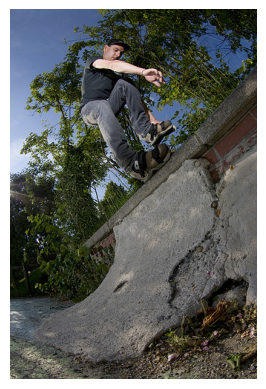

100%|██████████| 200/200 [00:00<00:00, 105265.50it/s]


Predicted Caption: with and is. white shirt on blue are while pool, man woman wearing children green go of swimmer


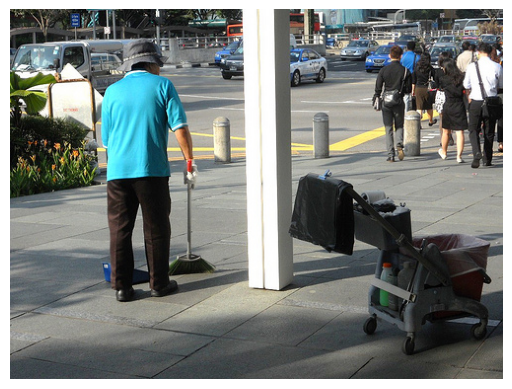

100%|██████████| 200/200 [00:00<00:00, 90297.18it/s]


Predicted Caption: with and blue is shirt white. on man, are woman pool while wearing green children has ofd


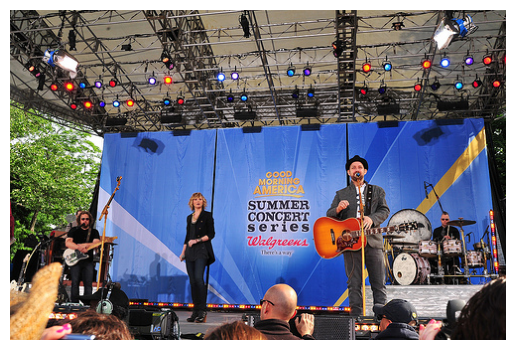

100%|██████████| 200/200 [00:00<00:00, 91578.69it/s]


Predicted Caption: with blue and is on shirt. white are of man pool, woman children while wearingd what purple


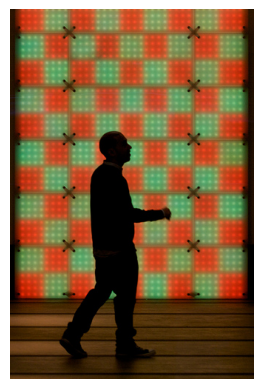

100%|██████████| 200/200 [00:00<00:00, 91859.48it/s]


Predicted Caption: with and is white. blue shirt on man are pool, while woman wearing children green of go has


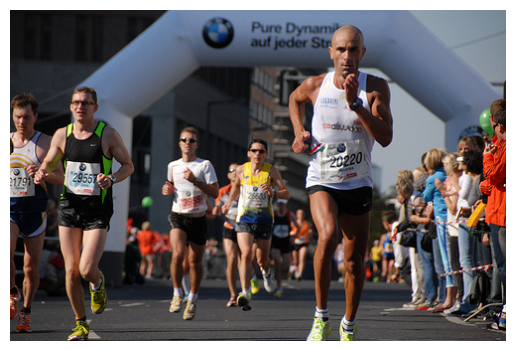

100%|██████████| 200/200 [00:00<00:00, 87072.95it/s]


Predicted Caption: with and is. white blue shirt on man are woman pool, while wearing children green of three go


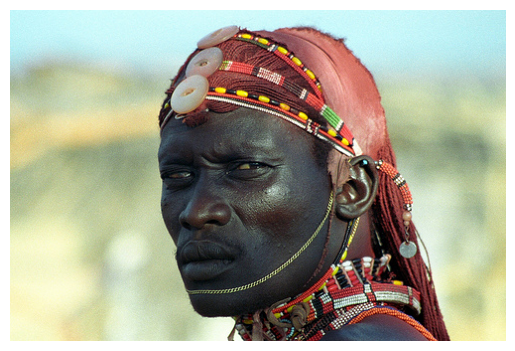

100%|██████████| 200/200 [00:00<00:00, 87875.63it/s]


Predicted Caption: with and is white. shirt blue on pool are while man, wearing go woman green children swimmer three


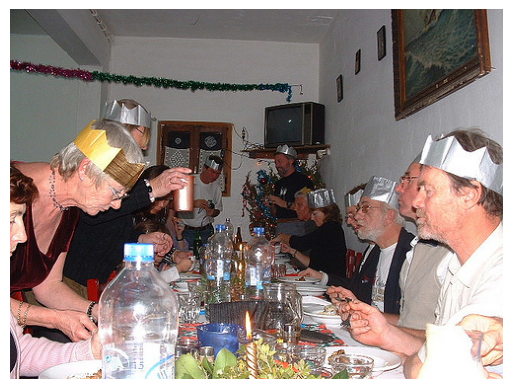

100%|██████████| 200/200 [00:00<00:00, 87949.34it/s]


Predicted Caption: with on of is and pool are blue shirt. children what process three white suburban wearing into man while


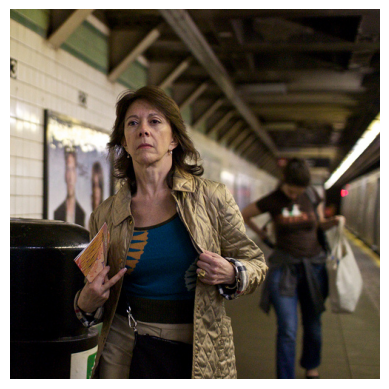

100%|██████████| 200/200 [00:00<00:00, 87381.33it/s]


Predicted Caption: with and is. white on blue shirt while pool are, woman wearing man children green go of swimmer


100%|██████████| 200/200 [00:00<00:00, 87765.31it/s]


Predicted Caption: with on is and blue shirt of. are white pool children woman, man while wearing three process what


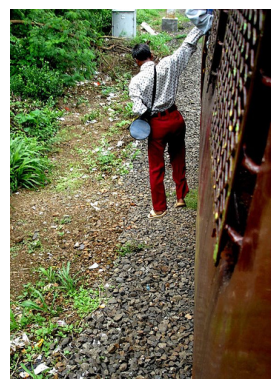

100%|██████████| 200/200 [00:00<00:00, 92212.91it/s]

Predicted Caption: with and blue is shirt white. on are man, pool woman while wearing of children green hasd


In [42]:
# Predict for a range of images
for index in range(110, 120):
  plt.imshow(ds.image[index].numpy())
  plt.axis('off')
  plt.show()

  test_image = ds.image[index]
  processed_test_image = process_image(test_image).unsqueeze(0)
  predicted_caption = predict_new(cnn_feature_extraction, embedder, decoder, post_processor, processed_test_image, device)
  print(f"Predicted Caption: {predicted_caption}")

# Part II(b) : Image Captioning Testing

In [43]:
!pip install tqdm
!pip install torch torchvision Pillow numpy tqdm

In [44]:
import unittest
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import collections

Image Captioning

In [45]:
class TestImageCaptioningComponents(unittest.TestCase):
    """
    Sets up and runs image captioning tests
    """
    def setUp(self):
        self.vocab_size = 1000
        self.max_length = 20
        self.embed_dim = 256
        self.num_heads = 1
        self.dropout = 0.1
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # initialize using our classes
        self.embedding = Embedding(self.vocab_size, self.max_length, self.embed_dim).to(self.device)
        self.self_attention = SelfAttention(self.num_heads, self.embed_dim, self.dropout).to(self.device)
        self.cross_attention = CrossAttention(self.embed_dim, self.num_heads, self.dropout).to(self.device)
        self.feed_forward = FeedForward(self.embed_dim, self.dropout).to(self.device)

    # test for Embedding()
    def test_embedding_output_dim(self):
        caption = torch.randint(0, self.vocab_size, (1, self.max_length)).to(self.device)
        output = self.embedding(caption)
        self.assertEqual(output.shape, (1, self.max_length, self.embed_dim), "Embedding output dimensions are incorrect")

    # test for SelfAttention()
    def test_selfattention_output_dim(self):
        input_tensor = torch.rand(1, self.max_length, self.embed_dim).to(self.device)
        output = self.self_attention(input_tensor)
        self.assertEqual(output.shape, input_tensor.shape, "Self Attention output dimensions are incorrect")

    # test for CrossAttention()
    def test_crossattention_output_dim(self):
        caption_embedding = torch.rand(1, self.max_length, self.embed_dim).to(self.device)
        image_features = torch.rand(1, self.embed_dim).to(self.device)
        output=self.cross_attention(caption_embedding, image_features)
        self.assertEqual(output.shape, caption_embedding.shape, "Cross Attention output dimensions are incorrect")

    # test FeedForward()
    def test_feedforward_output_dim(self):
        input_tensor = torch.rand(1, self.max_length, self.embed_dim).to(self.device)
        output = self.feed_forward(input_tensor)
        self.assertEqual(output.shape, input_tensor.shape, "Feed Forward output dimensions are incorrect")

# Running the tests in the notebook
def run_tests():
    test_loader = unittest.TestLoader()
    test_suite = test_loader.loadTestsFromTestCase(TestImageCaptioningComponents)
    test_runner = unittest.TextTestRunner(verbosity=2)
    test_results = test_runner.run(test_suite)
    print(test_results)

In [46]:
run_tests()

test_crossattention_output_dim (__main__.TestImageCaptioningComponents) ... ok
test_embedding_output_dim (__main__.TestImageCaptioningComponents) ... ok
test_feedforward_output_dim (__main__.TestImageCaptioningComponents) ... ok
test_selfattention_output_dim (__main__.TestImageCaptioningComponents) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.075s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>


Test PostProcessing

In [47]:
class MockTokenizer:
    def __init__(self, base_vocab_size):
        self.base_vocab_size = base_vocab_size
        self.banned_tokens = ['[UNK]', '[PAD]', '[SEP]', '[CLS]', '[MASK]', 'the', 'a', 'in']
        self.vocab = {str(i): i for i in range(base_vocab_size)}
        self.vocab.update({token: base_vocab_size + i for i, token in enumerate(self.banned_tokens)})

    @property
    def vocab_size(self):
        # This should return the total size including the banned tokens
        return self.base_vocab_size + len(self.banned_tokens)

    def banned_tokens_ids(self):
        return [self.vocab[token] for token in self.banned_tokens]

In [48]:
class TestPostProcessing(unittest.TestCase):
    def setUp(self):
        self.embed_dim = 256
        self.base_vocab_size = 1000  # Base vocabulary size excluding banned tokens
        self.tokenizer = MockTokenizer(self.base_vocab_size)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.banned_tokens = self.tokenizer.banned_tokens
        self.post_processing = PostProcessing(self.embed_dim, self.tokenizer, self.banned_tokens).to(self.device)

    def test_initial_bias(self):
        """Test that initial bias is None."""
        self.assertIsNone(self.post_processing.bias, "Initial bias should be None.")

    def test_adapt_bias_modification(self):
        """ Test the bias computation and adaptation """
        dataset = [torch.tensor([1, 2, 3, 4, 0, 1, 2, 3, 4, 0]) for _ in range(10)]
        self.post_processing.adapt(dataset)

        banned_indices = [self.tokenizer.vocab.get(token, -1) for token in self.banned_tokens]
        banned_biases = {token: self.post_processing.bias[idx].item() for token, idx in zip(self.banned_tokens, banned_indices)}
        print("Banned biases:", banned_biases)

        self.assertTrue(all(self.post_processing.bias[1:5] < 0), "Regular token biases should be calculated and less negative.")

        for idx in banned_indices:
            self.assertTrue(self.post_processing.bias[idx] <= -1e6, f"Bias for banned token should be extremely negative.")

    def test_forward_output(self):
        """Test the forward pass output dimensions and values after bias has been set."""
        if self.post_processing.bias is None:
            dataset = [torch.tensor([1, 2, 3, 4, 0, 1, 2, 3, 4, 0]) for _ in range(10)]
            self.post_processing.adapt(dataset)

        input_tensor = torch.randn(1, 20, self.embed_dim).to(self.device)
        self.post_processing.bias = self.post_processing.bias.to(input_tensor.device)

        output = self.post_processing(input_tensor)
        self.assertEqual(output.shape, (1, 20, self.base_vocab_size + len(self.banned_tokens)), "Output dimensions should match (batch, sequence length, vocab size).")

In [49]:
def run_tests_postprocessing():
    test_loader = unittest.TestLoader()
    test_suite = test_loader.loadTestsFromTestCase(TestPostProcessing)
    test_runner = unittest.TextTestRunner(verbosity=2)
    test_results = test_runner.run(test_suite)
    print(test_results)

run_tests_postprocessing()

test_adapt_bias_modification (__main__.TestPostProcessing)
100%|██████████| 10/10 [00:00<00:00, 37183.55it/s]
ok
test_forward_output (__main__.TestPostProcessing)
Test the forward pass output dimensions and values after bias has been set. ... 

Banned biases: {'[UNK]': -1000000000.0, '[PAD]': -1000000000.0, '[SEP]': -1000000000.0, '[CLS]': -1000000000.0, '[MASK]': -1000000000.0, 'the': -1000000000.0, 'a': -1000000000.0, 'in': -1000000000.0}


100%|██████████| 10/10 [00:00<00:00, 64035.18it/s]
ok
test_initial_bias (__main__.TestPostProcessing)
Test that initial bias is None. ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.018s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>


In [50]:
class MockTokenizer_cap:
    def __init__(self):
        # Create a vocabulary that the PostProcessing class can use to map names to IDs
        self.vocab = {str(i): i for i in range(100)}  # Example vocabulary with 100 tokens
        self.banned_tokens = ['[UNK]', '[PAD]', '[SEP]', '[CLS]', '[MASK]', 'the', 'a', 'in']
        self.vocab = {**self.vocab, **{token: 100 + i for i, token in enumerate(self.banned_tokens)}}


    def encode(self, text):
        # Simulate encoding text into a sequence of token IDs
        return [self.vocab[str(i)] for i in range(len(text.split()))]

    def decode(self, tokens):
        # Simulate decoding a sequence of token IDs back into text
        return ' '.join(str(token) for token in tokens)

    @property
    def vocab_size(self):
        return len(self.vocab)


In [51]:
class TestImageCaption(unittest.TestCase):
    def setUp(self):
        self.tokenizer = MockTokenizer_cap()
        self.model = ImageCaption(
            self.tokenizer, vocab_size=100, num_layers=1, embed_dim=256, max_length=20, num_heads=2, dropout=0.1
        )
        self.model.eval()
        mock_captions = torch.randint(0, 100, (100, 20))
        self.model.post_processing_model.adapt(mock_captions)


    def test_initialization(self):
        """ Test if the model initializes without errors """
        self.assertIsInstance(self.model, ImageCaption)



    def test_component_interaction(self):
        """ Test interactions between components within the model """
        dummy_image = torch.rand(1, 3, 224, 224).to(device)
        dummy_caption = "another test caption"
        tokens = torch.tensor([self.tokenizer.encode(dummy_caption)]).to(device)

        # Forward pass
        image_features = self.model.feature_extractor_model(dummy_image)
        token_embeddings = self.model.embedding(tokens)
        decoded_output = self.model.decoder_layer((image_features, token_embeddings))
        final_output = self.model.post_processing_model(decoded_output)

        self.assertTrue(torch.is_tensor(image_features))
        self.assertTrue(torch.is_tensor(token_embeddings))
        self.assertTrue(torch.is_tensor(decoded_output))
        self.assertTrue(torch.is_tensor(final_output))

    def test_error_handling(self):
        """ Test the model's error handling for incorrect inputs """
        with self.assertRaises(Exception):
            self.model((torch.rand(5, 5), "wrong input type for caption"))

In [52]:
def run_tests_caption():
    test_loader = unittest.TestLoader()
    test_suite = test_loader.loadTestsFromTestCase(TestImageCaption)
    test_runner = unittest.TextTestRunner(verbosity=2)
    test_results = test_runner.run(test_suite)
    print(test_results)

run_tests_caption()

test_component_interaction (__main__.TestImageCaption)
100%|██████████| 100/100 [00:00<00:00, 53814.52it/s]l ... 
ok
test_error_handling (__main__.TestImageCaption)
100%|██████████| 100/100 [00:00<00:00, 55797.58it/s] ... 
ok
test_initialization (__main__.TestImageCaption)
100%|██████████| 100/100 [00:00<00:00, 58620.60it/s]
ok

----------------------------------------------------------------------
Ran 3 tests in 1.601s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>


# Part III: Caption to Story

In [53]:
!pip install wordfreq

In [54]:
from transformers import pipeline
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
import math
from wordfreq import word_frequency
import re
import numpy as np

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/joshdeleeuw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/joshdeleeuw/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [55]:
def captions_to_story_pretrained(captions):
    """
    Function to take in captions, and output a story (a summary of the
    video, with overall insights)
    """
    long_text = '.'.join(captions)
    summarizer = pipeline("summarization")
    result = summarizer(long_text)
    print (result)


def preprocessing(captions):
    """
    Takes in a list of captions (or just a long string of text), returns
    1. tokenized matrix of words in each sentence (list of lists)
    2. the actual sentences (list of strings)
    """
    # handles strings, splitting into list
    if type(captions) == str:
        captions = re.split(r"(?<=[.?!])", captions)
    # ensure every caption ends in a period
    for i in range(len(captions)):
        if len(captions[i]) == 0:
          continue
        if captions[i][-1] not in  ".?!":
            captions[i] = captions[i] + "."
    paragraph = ' '.join(captions)
    sentences = nltk.sent_tokenize(paragraph)
    res = []
    for sentence in sentences:
        res.append(nltk.word_tokenize(sentence))
    return res, sentences

def build_frequency_table(tokens, stops):
    """
    Builds frequency table of words in a sentence (a mapping of words
    to the number of times they appear). Does not include "stop" words
    (e.g. , or . or ! or ?)
    """
    table = {}
    for word in tokens:
        if word not in stops:
            to_add = word.lower()
            if to_add in table:
                table[to_add] += 1
            else:
                table[to_add] = 1
    return table

def build_frequency_matrix(sentences, stops):
    """
    Builds frequency matrix. For each sentence, a mapping from words to the
    number of times they appear in the setence. Excludes words in "stops" (
    , or . or ! or ?)
    """
    matrix = {}
    for i in range(len(sentences)):
        table = build_frequency_table(sentences[i], stops)
        matrix[i] = table
    return matrix

def build_tf_matrix(matrix):
    """
    Takes in word frequency matrix, outputs TF matrix (a matrix of
    word probabilities in each sentence). Essentially, normalizing by the
    number of words in each sentence, so the sum of each row is 1
    """
    res = {}
    for key, table in matrix.items():
        tot = sum(table.values())
        freq_table = {}
        for word, count in table.items():
            freq_table[word] = count/tot
        res[key] = freq_table
    return res

def build_appearing_matrix(matrix):
    """
    Takes in word frequency (or tf) matrix - works with either - and produces
    a mapping from word to number of sentences it appears in. This is needed
    to produce idf matrix
    """
    appearances = {}
    for key, sentence in matrix.items():
        for word in sentence:
            if word in appearances:
                appearances[word] += 1
            else:
                appearances[word] = 1
    return appearances

def build_idf_matrix(freq_matrix, appearing_matrix):
    """
    Takes in frequence of each word in each sentence (freq matrix), and the
    number of sentences each word appears in (appearing_matrix) and produces
    the idf matrix
    """
    idf_matrix = {}
    num_sentences = len(freq_matrix)
    for key, sentence in freq_matrix.items():
        idf_table = {}
        for word in sentence:
            idf_table[word] = math.log(num_sentences/appearing_matrix[word])
        idf_matrix[key] = idf_table
    return idf_matrix

def build_tf_idf_matrix(tf_matrix, idf_matrix):
    """
    Builds tf-idf matrix for tf-idf algorithm, using both tf and idf
    matrices
    """
    tf_idf_matrix = {}
    for key, sentence in tf_matrix.items():
        idf_sentence = idf_matrix[key]
        tf_idf_table = {}
        for word in idf_sentence:
            tf_idf_table[word] = sentence[word] * idf_sentence[word]
        tf_idf_matrix[key] = tf_idf_table
    return tf_idf_matrix



In [56]:
def sentence_scoring(tf_idf_matrix):
    """
    Returns average tf-idf score of words in a sentence. To be used
    when selecting sentences in the tf-idf algorithm
    """
    scores = {}
    for key, sentence in tf_idf_matrix.items():
        avg_score = np.mean(list(sentence.values()))
        scores[key] = avg_score
    return scores

def choose_sentences_tfidf(sentence_scores, threshold):
    """
    Takes in sentences scores (as calculated by
    tf-idf algo) and a threshold for inclusion (e.g. 1.3). Returns
    sentences to be included in summary
    """
    scores = list(sentence_scores.values())
    average = np.mean(scores)
    sd = np.std(scores)
    res = []
    for key in sentence_scores:
        if sentence_scores[key] > (average + sd * threshold):
            res.append(key)
    return res

def choose_sentences_tfidf_modified(sentence_scores, idf_matrix, threshold):
    """
    Modified version of the tf-idf algorithm. Chooses sentences both according
    to tf-idf, and sentences with relatively uncommon english words that appear
    frequently in the text
    """
    # first, find tf-idf sentences to include
    scores = list(sentence_scores.values())
    average = np.mean(scores)
    sd = np.std(scores)
    res = []
    for key in sentence_scores:
        if sentence_scores[key] > (average + threshold * sd):
            res.append(key)
    # now, find relatively unique words that appear frequently
    # include their sentences in the summary as well
    rare_words_used = set()
    for key, sentence in idf_matrix.items():
        average_idf = sum(sentence.values())/len(sentence)
        for word in sentence:
            if word not in rare_words_used:
              if word_frequency(word, "en") < 5e-5 and sentence[word] < 0.8 * average_idf:
                rare_words_used.add(word)
                res.append(key)
                break
    res.sort()
    # if we haven't selected any sentences (nothing meets criteria), select 10%
    # of sentences, at random
    # This is a modification we are making ONLY FOR DEMO, 
    # due to similarity of captions
    if len(res) == 0:
        to_select = len(sentence_scores)//10 + 1
        res = random.sample(list(sentence_scores.keys()), to_select)


    return res

In [57]:
def write_summary(sentences, lst):
    """
    Takes in the actual sentences, and a list of indices to be included,
    creates text summary
    """
    if len(lst) == 0:
        return ""
    summary = ""
    for key in lst:
        summary += sentences[key]
        summary += " "
    return summary

def print_caption(caption):
    """
    Utility function fo printing captions
    """
    if type(caption) == str:
        print (caption)
        return
    for i in range(len(caption)):
        if len(caption) == 0 or caption[i][-1] not in ".!?":
            caption[i] += "."
    res = ' '.join(caption)
    print (res)

def full_pipeline(caption):
    """
    Takes a caption (either string or list of strings) and returns it summary,
    according to a modified version of the tf-idf algorithm
    """
    tokens, sentences = preprocessing(caption)
    # build relevant matrices
    freq_matrix = build_frequency_matrix(tokens, ",.!?")
    tf_matrix = build_tf_matrix(freq_matrix)
    appearing_matrix = build_appearing_matrix(freq_matrix)
    idf_matrix = build_idf_matrix(freq_matrix, appearing_matrix)
    tf_idf_matrix = build_tf_idf_matrix(tf_matrix, idf_matrix)
    # score sentences according to tf-idf metrics and modifications
    sentence_scores = sentence_scoring(tf_idf_matrix)
    to_include = choose_sentences_tfidf_modified(sentence_scores, idf_matrix, 0.25)
    # after choosing sentences to include, write summary
    summary = write_summary(sentences, to_include)
    return summary

In [58]:
def assert_dictionaries_equal(dict1, dict2):
    """
    Checks if two dictionaries of integers (or dictionaries of
    dictionaries of integers, or dictionaries of dictionaries of dictionaries...)
    are equal, by utilizing assert statements
    """
    assert len(dict1) == len(dict2)
    for key, value in dict1.items():
        assert key in dict2
        if isinstance(value, dict):
            assert_dictionaries_equal(value, dict2[key])
        else:
          dict2_val = dict2[key]
          assert value - dict2_val < 0.001


def test_1():
    sample_caption = ["hello world world.",
                      "world hello test.",
                      "test test test hello."
                      ]
    tokens, sequence = preprocessing(sample_caption)
    freq_matrix = build_frequency_matrix(tokens, ',.!?')
    tf_matrix = build_tf_matrix(freq_matrix)
    target_tf = {0: {"hello": 0.333333, "world": 0.6666666},
              1: {"world": 0.333333, "hello": 0.333333, "test": 0.333333},
              2: {"hello": 0.25, "test": 0.75}}
    assert_dictionaries_equal(tf_matrix, target_tf)
    appearing_matrix = build_appearing_matrix(freq_matrix)
    idf_matrix = build_idf_matrix(freq_matrix, appearing_matrix)
    target_idf = {0: {"hello": math.log(3/3), "world": math.log(3/2)},
              1: {"world": math.log(3/2), "hello": math.log(3/3), "test": math.log(3/2)},
              2: {"hello": math.log(3/3), "test": math.log(3/2)}}
    assert_dictionaries_equal(idf_matrix, target_idf)
    tf_idf_matrix = build_tf_idf_matrix(tf_matrix, idf_matrix)
    sentence_scores = sentence_scoring(tf_idf_matrix)
    target_sentences = {0: 0.13515503603605478,
                        1: 0.09010335735736985,
                        2: 0.15204941554056164}
    assert_dictionaries_equal(sentence_scores, target_sentences)
    print ("Test 1 passed")

def test_2():
    sample_caption = ["video image caption.",
                      "caption image caption.",
                      "image image image random."
                      ]
    tokens, sequence = preprocessing(sample_caption)
    freq_matrix = build_frequency_matrix(tokens, ',.!?')
    tf_matrix = build_tf_matrix(freq_matrix)
    target_tf = {0: {"video": 0.333333, "image": 0.333333, "caption": 0.3333333},
              1: {"image": 0.333333, "caption": 0.6666666},
              2: {"image": 0.75, "random": 0.25}}
    assert_dictionaries_equal(tf_matrix, target_tf)
    appearing_matrix = build_appearing_matrix(freq_matrix)
    idf_matrix = build_idf_matrix(freq_matrix, appearing_matrix)
    target_idf = {0: {"video": math.log(3), "image": math.log(3/3), "caption": math.log(3/2)},
              1: {"image": math.log(3/3), "caption": math.log(3/2)},
              2: {"image": math.log(3/3), "random": math.log(3)}}
    assert_dictionaries_equal(idf_matrix, target_idf)
    tf_idf_matrix = build_tf_idf_matrix(tf_matrix, idf_matrix)
    sentence_scores = sentence_scoring(tf_idf_matrix)
    target_sentences = {0: 0.16711971075291934,
                        1: 0.13515503603605478,
                        2: 0.13732653608351372}
    assert_dictionaries_equal(sentence_scores, target_sentences)
    print ("Test 2 passed")


def test_3():
    sample_caption = ["cs 4701 4700.",
                      "47 47 4701 prac.",
                      "artificial intelligence prac."
                      ]
    tokens, sequence = preprocessing(sample_caption)
    freq_matrix = build_frequency_matrix(tokens, ',.!?')
    tf_matrix = build_tf_matrix(freq_matrix)
    target_tf = {0: {"cs": 0.333333, "4700": 0.333333, "4701": 0.3333333},
              1: {"4701": 0.25, "47": 0.5, "prac": 0.25},
              2: {"artificial": 0.333333, "intelligence": 0.333333, "prac": 0.3333333}}
    assert_dictionaries_equal(tf_matrix, target_tf)
    appearing_matrix = build_appearing_matrix(freq_matrix)
    idf_matrix = build_idf_matrix(freq_matrix, appearing_matrix)
    target_idf = {0: {"cs": math.log(3), "4700": math.log(3), "4701": math.log(3/2)},
              1: {"4701": math.log(3/2), "47": math.log(3), "prac": math.log(3/2)},
              2: {"artificial": math.log(3), "intelligence": math.log(3), "prac": math.log(3/2)}}
    assert_dictionaries_equal(idf_matrix, target_idf)
    tf_idf_matrix = build_tf_idf_matrix(tf_matrix, idf_matrix)
    sentence_scores = sentence_scoring(tf_idf_matrix)
    target_sentences = {0: 0.28918774282715376,
                        1: 0.25067956612937903,
                        2: 0.2891877428271537}
    assert_dictionaries_equal(sentence_scores, target_sentences)
    print ("Test 3 passed")

In [59]:
def software_engineering_test_suite():
    """
    Tests that examine each function individually, ensuring results agree
    with expected values. These tests are meant to ensure correctness of the
    algorithm, rather than performance metrics.
    """
    print ("Starting software engineering style tests\n")
    test_1()
    test_2()
    test_3()


def machine_learning_test_suite(many_captions):
    """
    Runs the algorithm on multiple blocks of captions, and prints out the
    results - used to ensure quality of the algorithm
    """
    for caption in many_captions:
        print ("ORIGINAL TEXT IS: \n")
        print_caption(caption)
        print ()
        # tokens, sentences = preprocessing(caption)
        # freq_matrix = build_frequency_matrix(tokens, ",.!?")
        # tf_matrix = build_tf_matrix(freq_matrix)
        # appearing_matrix = build_appearing_matrix(freq_matrix)
        # idf_matrix = build_idf_matrix(freq_matrix, appearing_matrix)
        # tf_idf_matrix = build_tf_idf_matrix(tf_matrix, idf_matrix)
        # sentence_scores = sentence_scoring(tf_idf_matrix)
        # to_include = choose_sentences_tfidf_modified(sentence_scores, idf_matrix, 0.25)
        # summary = write_summary(sentences, to_include)
        summary = full_pipeline(caption)
        print ("SUMMARIZED TEXT IS: \n")
        print (summary)
        print ()

In [60]:
caption_1 = [
    "The small diner at the edge of town buzzed with quiet conversation and the clatter of dishes.",
    "Ella sat in her usual booth, staring out the window as the rain streaked the glass.",
    "Her coffee had grown cold, untouched, as she nervously glanced at the clock on the wall.",
    "She wasn’t sure if he would come — it had been years since their last conversation.",
    "Just as she was about to leave, the door jingled, and a familiar figure stepped inside.",
    "James looked almost the same, though a little older, his hair flecked with gray.",
    "He spotted her immediately and gave a hesitant smile before making his way over.",
    "“I wasn’t sure you’d actually show up,” Ella said, her voice soft but steady.",
    "“I almost didn’t,” James admitted as he slid into the seat across from her.",
    "For a moment, they sat in silence, the sound of rain filling the space between them.",
    "“So,” Ella began, breaking the tension, “how’s life been treating you?”",
    "James chuckled nervously, rubbing the back of his neck. “Complicated. But I guess that’s why I’m here.”",
    "Their conversation flowed slowly at first, but soon the years between them seemed to melt away.",
    "When the rain finally stopped, Ella felt a strange sense of relief, like something heavy had lifted.",
    "As they stepped out of the diner together, she realized that some doors, once reopened, might not close again."
]


caption_2 = [
    "It was a chilly morning as Jack set off on his daily jog through the park.",
    "The fog hung low, giving the trees a mysterious, almost magical appearance.",
    "As he ran, he spotted an old, abandoned bench that he hadn’t noticed before.",
    "Something about it seemed intriguing, so he stopped and walked over to take a closer look.",
    "On the bench, he found a small, dusty book with a faded leather cover.",
    "Curious, he picked it up and opened it to the first page.",
    "Inside, there was a note that read, To whoever finds this, may your journey be filled with wonder.",
    "Jack felt a thrill of excitement, wondering who had left the book and why.",
    "He tucked it under his arm and continued his run, feeling as if he’d stumbled into an adventure.",
    "Little did he know, this was just the beginning of an unexpected journey."
]


In [61]:
machine_learning_test_suite([caption_1, caption_2])

software_engineering_test_suite()

ORIGINAL TEXT IS: 

The small diner at the edge of town buzzed with quiet conversation and the clatter of dishes. Ella sat in her usual booth, staring out the window as the rain streaked the glass. Her coffee had grown cold, untouched, as she nervously glanced at the clock on the wall. She wasn’t sure if he would come — it had been years since their last conversation. Just as she was about to leave, the door jingled, and a familiar figure stepped inside. James looked almost the same, though a little older, his hair flecked with gray. He spotted her immediately and gave a hesitant smile before making his way over. “I wasn’t sure you’d actually show up,” Ella said, her voice soft but steady. “I almost didn’t,” James admitted as he slid into the seat across from her. For a moment, they sat in silence, the sound of rain filling the space between them. “So,” Ella began, breaking the tension, “how’s life been treating you?”. James chuckled nervously, rubbing the back of his neck. “Complicate

# Part IV : Entire System

In [62]:
# video to frames
video_path = "try.mp4"
image_directory = "extracted_images"
gap = 20
extracted_images = extract_frames_with_opencv(video_path, image_directory, gap)

# image retreival, processing, captioning
image_files = [file for file in os.listdir(image_directory) if file.endswith(".jpg")]

caption_list = []
for file in image_files:
  image = Image.open(os.path.join(image_directory, file))
  image = image.convert('RGB')
  transformation = transforms.ToTensor()
  image_tensor = transformation(image)
  image_tensor = image_tensor.permute(1, 2, 0)
  image_tensor_fixed = image_tensor.to(torch.uint8)

  processed_image = process_image(image_tensor_fixed).unsqueeze(0).to(device)
  predicted_caption = predict_new(cnn_feature_extraction, embedder, decoder, post_processor, processed_test_image, device)
  words = predicted_caption.split()
  new_words = list(filter(lambda x : x not in ".!?", words))
  for i in range(len(new_words)):
    if new_words[i][-1] in ".!?":
      new_words[i] = new_words[i][:-1]
  caption_list.append(' '.join(new_words))

print ()
print ("ORIGINAL TEXT IS: \n")
print_caption(caption_list)
print ()
summary = full_pipeline(caption_list)
print ("SUMMARIZED TEXT IS: \n")
print (summary)
print ()


Video FPS: 25, Total frames: 216
Saved frame 0 to extracted_images/frame_0.jpg
Saved frame 20 to extracted_images/frame_20.jpg
Saved frame 40 to extracted_images/frame_40.jpg
Saved frame 60 to extracted_images/frame_60.jpg
Saved frame 80 to extracted_images/frame_80.jpg
Saved frame 100 to extracted_images/frame_100.jpg
Saved frame 120 to extracted_images/frame_120.jpg
Saved frame 140 to extracted_images/frame_140.jpg
Saved frame 160 to extracted_images/frame_160.jpg
Saved frame 180 to extracted_images/frame_180.jpg
Saved frame 200 to extracted_images/frame_200.jpg
End of video or frame read failed at frame 216.
Total frames processed: 216
Total frames saved: 11


100%|██████████| 200/200 [00:00<00:00, 68523.18it/s]


ORIGINAL TEXT IS: 

with and blue is shirt white on are man, pool woman while wearing of children green hasd. with and blue is shirt white on are man, pool woman while wearing of children green hasd. with and blue is shirt white on are man, pool woman while wearing of children green hasd. with and blue is shirt white on are man, pool woman while wearing of children green hasd. with and blue is shirt white on are man, pool woman while wearing of children green hasd. with and blue is shirt white on are man, pool woman while wearing of children green hasd. with and blue is shirt white on are man, pool woman while wearing of children green hasd. with and blue is shirt white on are man, pool woman while wearing of children green hasd. with and blue is shirt white on are man, pool woman while wearing of children green hasd. with and blue is shirt white on are man, pool woman while wearing of children green hasd. with and blue is shirt white on are man, pool woman while wearing of children g